# Image Classification with Convolutional Neural Networks

Original code at: https://github.com/ageron/handson-ml/blob/master/13_convolutional_neural_networks.ipynb

### Make the notebook compatible with both Python 2 and 3

http://python-future.org/compatible_idioms.html

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import numpy as np
import tensorflow as tf

### Plot graphs inline

In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [11]:
print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.13.1
1.16.2
3.0.3


### Download and extract the MNIST libraries

The original site where this dataset is available: http://yann.lecun.com/exdb/mnist/

In [12]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

# Store the MNIST data in mnist_data/
mnist = input_data.read_data_sets("mnist_data/")

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### Helper function to display one digit image

Reshape the data from 1-D array to a 2-D array of 28x28 pixels

In [34]:
def display_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap="Greys", interpolation='nearest')

### Access the training and test data and the corresponding labels

In [14]:
training_digits, training_labels = mnist.train.next_batch(10000)
test_digits, test_labels = mnist.test.next_batch(200)

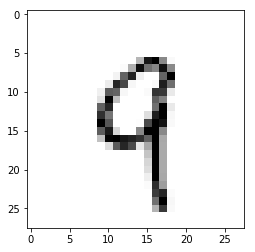

In [15]:
display_digit(training_digits[1])

In [16]:
training_labels[:5]

array([6, 9, 8, 5, 6], dtype=uint8)

### Dimensions of MNIST images

* Each image is 28x28 pixels
* The images are grayscale and have just one channel
* The number of inputs is equal to the number of pixels in each image

In [17]:
height = 28
width = 28
channels = 1
n_inputs = height * width

### Set up a CNN with 2 convolutional layers and one max pool layer

* Specify the number of **feature maps** in each layer, a feature map highlights that area in an image which is most similar to the filter applied
* The kernel size indicates the **dimensions of the filter** which is applied to the image. The filter variables are created for you and initialized randomly
* The stride is the steps by which the filter moves over the input, the **distance between two receptive fields on the input**
* "SAME" padding indicates that the convolutional layer **uses zero padding** on the inputs and will consider all inputs

In [18]:
conv1_feature_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = "SAME"

In [19]:
conv2_feature_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = "SAME"

In [20]:
pool3_feature_maps = conv2_feature_maps

### One fully connected layer

* 64 neurons in the layer
* 10 outputs corresponding to the digits 0-9

In [21]:
n_fullyconn1 = 64
n_outputs = 10

In [22]:
tf.reset_default_graph()

### Placeholders for training data and labels

* The training dataset placeholder can have any number of instances and each instance is an array of n_inputs = 28x28 = 784 pixels
* The images are fed to the convolutional layer as a 4D tensor *[batch_size, height, width, channels]*

In [23]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])

In [24]:
y = tf.placeholder(tf.int32, shape=[None], name="y")

### Connect the convolutional layers

* Each layer uses the ReLU activation function

In [25]:
conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_feature_maps,
                         kernel_size=conv1_kernel_size,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


In [26]:
conv2 = tf.layers.conv2d(conv1, filters=conv2_feature_maps, 
                         kernel_size=conv2_kernel_size,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

### Connect a max pooling layer

* The filter is a 2x2 filter
* The stride is 2 both horizontally and vertically
* This results in an image that is **1/4th the size of the original image**
* Reshape the pooled layer to be a **1-D vector (flatten it)**. It now has only 1/4th the number of pixels in each feature map

In [27]:
pool3 = tf.nn.max_pool(conv2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding="VALID")

pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps * 7 * 7])

In [28]:
fullyconn1 = tf.layers.dense(pool3_flat, n_fullyconn1,
                             activation=tf.nn.relu, name="fc1")

Instructions for updating:
Use keras.layers.dense instead.


### The final output layer with softmax activation

Do not apply the softmax activation to this layer. The *tf.nn.sparse_softmax_cross_entropy_with_logits* will apply the softmax activation as well as calculate the cross-entropy as our cost function

In [29]:
logits = tf.layers.dense(fullyconn1, n_outputs, name="output")

### Cross-entropy as a cost function

* Use the Adam optimizer which in most cases performs better than the simple gradient descent

In [30]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,
                                                          labels=y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

### Check correctness and accuracy of the prediction

* Check whether the highest probability output in logits is equal to the y-label
* Check the accuracy across all predictions (How many predictions did we get right?)

In [31]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [32]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Train with the training data, measure accuracy with test data

In [33]:
n_epochs = 5
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Train accuracy: 1.0 Test accuracy: 0.9752
1 Train accuracy: 0.99 Test accuracy: 0.9812
2 Train accuracy: 0.99 Test accuracy: 0.9867
3 Train accuracy: 1.0 Test accuracy: 0.9866
4 Train accuracy: 0.99 Test accuracy: 0.9895
